# DeepLearning Assignment 1 实验报告
# SA22221042 汪泱泱

## 一、实验过程


In [1]:
import torch
import time
import torch.nn.functional as F
import numpy as np
import random

from torch import nn
from sklearn import datasets
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


在$[0,4\pi)$随机生成样本x，根据$y=\sin(x)+e^{-x}$计算对应的y值

In [2]:
num_samples = 10000
x = np.random.uniform(0, 4*np.pi, num_samples)
np.random.shuffle(x)
x = x.reshape(-1, 1)
x = torch.tensor(x, dtype=torch.float32)
y = torch.sin(x) + torch.exp(-x)

按照7:1:2划分训练集、验证集、测试集

In [3]:
train_rate = 0.7
validation_rate = 0.1
test_rate = 0.2
train_samples = round(num_samples * train_rate)
validation_samples = round(num_samples * (train_rate + validation_rate))
train_x = x[:train_samples]
train_y = y[:train_samples]
validation_x = x[train_samples:validation_samples]
validation_y = y[train_samples:validation_samples]
test_x = x[validation_samples:]
test_y = y[validation_samples:]

 将划分好的训练集、验证集、测试集从Tensor格式转化成DataLoader格式

In [4]:
batch_size=256

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

dataset = TensorDataset(validation_x, validation_y)
validation_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
)

神经网络模型的类，继承nn.Module。

由于仅需要拟合一维函数，所以神经网络仅由全连接层和激活函数两种网络组成。

由于后面要分析网络深度、网络宽度、激活函数对模型性能的影响，所以先不将网络深度、网络宽度、激活函数写死，而是通过初始化函数的参数决定。


In [5]:
class Model(nn.Module):
    activation_dict = {
        'Logistic': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'ReLU': nn.ReLU(),
        'ELU': nn.ELU(),
        'Softplus': nn.Softplus()
    }
    def __init__(self, hidden_layer_num, layer_size, activation):
        super().__init__()
        assert hidden_layer_num>0
        self.activation = self.activation_dict[activation]
        self.fc_list = nn.ModuleList()
        self.fc_list.append(nn.Linear(1, layer_size))
        for i in range(hidden_layer_num-1):
            self.fc_list.append(nn.Linear(layer_size, layer_size))
        self.fc_list.append(nn.Linear(layer_size, 1))

    def forward(self, x):
        for i in range(len(self.fc_list)):
            x = self.fc_list[i](x)
            if i != len(self.fc_list)-1:
                x = self.activation(x)
        return x


先选择ReLU激活函数、隐藏层层数5、每层100个神经元实例化模型。

使用Adam优化器，学习率先设置为1e-4

将模型放在gpu上，以加速模型训练

In [6]:
activation = 'ReLU'
hidden_layer_num = 5
layer_size = 100
model = Model(hidden_layer_num, layer_size, activation)
n_gpu = torch.cuda.device_count()
device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
model = model.to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/data1/wangyy/anaconda3/envs/dagan/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


对模型进行训练，根据要求选择MSE作为损失函数，每隔10个epoch记录训练集和验证集上的损失，以备作图

In [7]:
Loss = nn.MSELoss()
epochs = 200
train_losses = []
validation_losses = []
for epoch in range(epochs):
    for batch_id, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = Loss(y, output)
        loss.backward()
        optimizer.step()
    if (epoch+1)%10 == 0:
        print('[Epoch {}/{}] Train Loss = {:.4f}, Validation Loss = {:.5f}'
        .format(epoch + 1, epochs, Loss(train_y, model(train_x)), Loss(validation_y, model(validation_x))))
        train_losses.append(float(Loss(train_y, model(train_x)).detach().numpy()))
        validation_losses.append(float(Loss(validation_y, model(validation_x))))

[Epoch 10/200] Train Loss = 0.3371, Validation Loss = 0.34457
[Epoch 20/200] Train Loss = 0.2020, Validation Loss = 0.20970
[Epoch 30/200] Train Loss = 0.0480, Validation Loss = 0.04428
[Epoch 40/200] Train Loss = 0.0357, Validation Loss = 0.03219
[Epoch 50/200] Train Loss = 0.0268, Validation Loss = 0.02386
[Epoch 60/200] Train Loss = 0.0187, Validation Loss = 0.01632
[Epoch 70/200] Train Loss = 0.0114, Validation Loss = 0.00968
[Epoch 80/200] Train Loss = 0.0061, Validation Loss = 0.00489
[Epoch 90/200] Train Loss = 0.0031, Validation Loss = 0.00251
[Epoch 100/200] Train Loss = 0.0019, Validation Loss = 0.00170
[Epoch 110/200] Train Loss = 0.0010, Validation Loss = 0.00092
[Epoch 120/200] Train Loss = 0.0005, Validation Loss = 0.00045
[Epoch 130/200] Train Loss = 0.0003, Validation Loss = 0.00018
[Epoch 140/200] Train Loss = 0.0006, Validation Loss = 0.00070
[Epoch 150/200] Train Loss = 0.0001, Validation Loss = 0.00007
[Epoch 160/200] Train Loss = 0.0001, Validation Loss = 0.00008
[

作出训练误差和验证误差关于ehoch的折线图

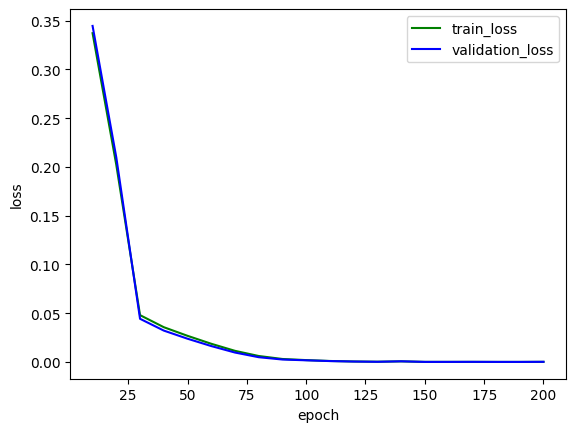

In [8]:
epoch_x = np.linspace(10, epochs, epochs//10).tolist()
plt.plot(epoch_x, train_losses, label="train_loss",color='g')
plt.plot(epoch_x, validation_losses, label="validation_loss",color='b')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

作出训练得到的模型在验证集上产生(x,y)的散点图（由于验证集样本较多，选取了其中300个点）

为了体现效果，我们将$y=\sin(x)+e^{-x}$在$[0,4\pi)$的图像绘制在同一张图上

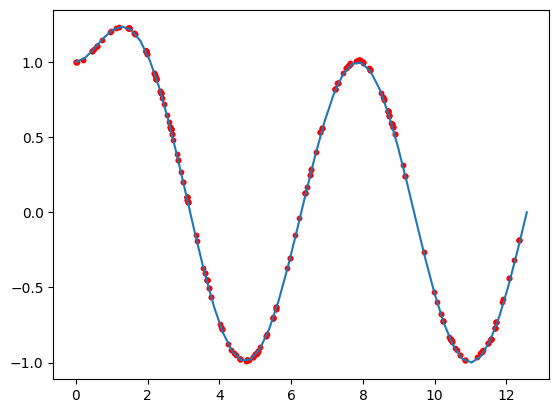

In [9]:
t = validation_x.clone()
random.shuffle(t)
x = t[:300]
y = model(x).detach().numpy()
plt.scatter(x, y, s=10, c='r')

x = np.linspace(0, 4*np.pi)
plt.plot(x, np.sin(x)+np.exp(-x))

可以发现，散点大都离目标函数图像较近，所以训练效果还是不错的。

## 二、探究网络超参数（深度、宽度、激活函数）和学习率对模型性能的影响

考虑从两个方面评估网络超参数和学习率对模型性能的影响：一是网络在验证集上的误差，二是网络的训练时间。所以对于每个超参，在控制其他超参不变的情况下，作出两个图：一是不同的超参网络误差随epoch增加变化折线图，二是不同的超参对应的训练时间折现/散点图。

#### 1、网络深度对模型的影响

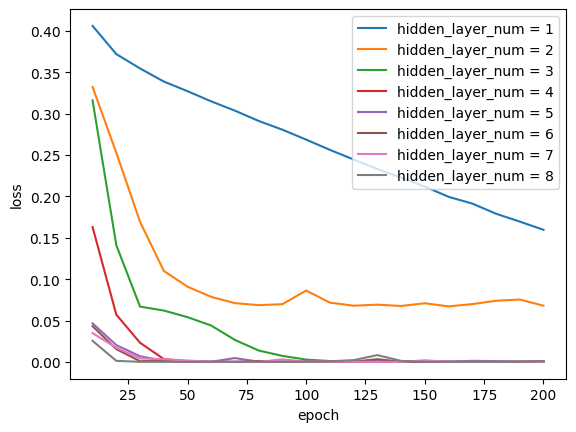

In [10]:
activation = 'ReLU'
layer_size = 100
validation_losses_dict = {}
time_list = []
for hidden_layer_num in range(1, 9):
    validation_losses_dict[hidden_layer_num] = []
    model = Model(hidden_layer_num, layer_size, activation)
    n_gpu = torch.cuda.device_count()
    device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
    model = model.to(device)
    learning_rate = 3e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Loss = nn.MSELoss()
    epochs = 200
    start_time = time.time()
    for epoch in range(epochs):
        for batch_id, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = Loss(y, output)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
#             print('[Epoch {}/{}] Validation Loss = {:.5f}'
#             .format(epoch + 1, epochs, Loss(validation_y, model(validation_x))))
            validation_losses_dict[hidden_layer_num].append(float(Loss(validation_y, model(validation_x))))
    time_list.append(time.time()-start_time)

epoch_x = np.linspace(10, epochs, epochs//10).tolist()
for hidden_layer_num in range(1, 9):
    plt.plot(epoch_x, validation_losses_dict[hidden_layer_num], label='hidden_layer_num = '+str(hidden_layer_num))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

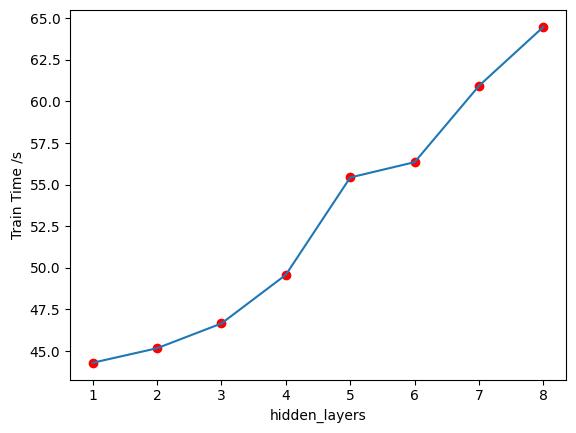

In [11]:
time_x = np.linspace(1, 8, 8)
plt.scatter(time_x, time_list, c='r')
plt.plot(time_x, time_list)
plt.xlabel('hidden_layers')
plt.ylabel('Train Time /s')
plt.show()

小结：

在神经网络隐藏层小于3层（即1层或2层）时，在200个epoch的训练后，模型要么未能收敛，要么在loss较大时就收敛了。说明此时模型的复杂程度不足以拟合$y=\sin(x)+e^{-x}$。

在神经网络隐藏层大于等于3层（3-8层）时，模型最后都可以收敛且loss接近0，这说明3层神经网络隐藏层就可以表达$y=\sin(x)+e^{-x}$在$[0,4\pi)$的信息了。且神经网络层数越高，收敛越快。在神经网络仅有3个隐藏层时，需要80个左右epochs收敛；而有8个隐藏层时，只需30个左右epochs即可收敛。

从训练时间的角度看，隐藏层越多，训练时间越长。

#### 2、学习率对模型的影响

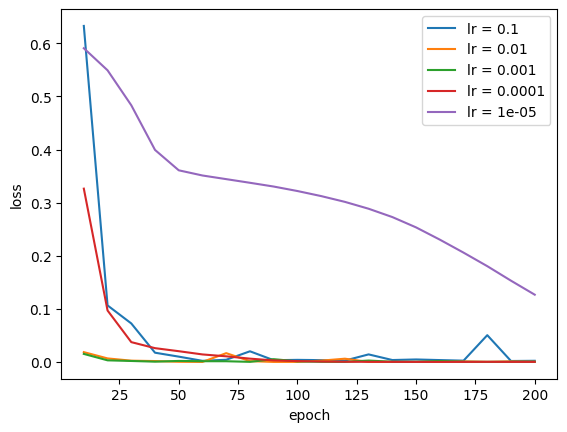

In [12]:
activation = 'ReLU'
layer_size = 100
hidden_layer_num = 5
validation_losses_dict = {}
time_list = []
learning_rate_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for i in range(len(learning_rate_list)):
    learning_rate = learning_rate_list[i]
    validation_losses_dict[i] = []
    model = Model(hidden_layer_num, layer_size, activation)
    n_gpu = torch.cuda.device_count()
    device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Loss = nn.MSELoss()
    epochs = 200
    start_time = time.time()
    for epoch in range(epochs):
        for batch_id, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = Loss(y, output)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            validation_losses_dict[i].append(float(Loss(validation_y, model(validation_x))))
    time_list.append(time.time()-start_time)

epoch_x = np.linspace(10, epochs, epochs//10).tolist()
for i in range(len(learning_rate_list)):
    plt.plot(epoch_x, validation_losses_dict[i], label='lr = '+str(learning_rate_list[i]))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

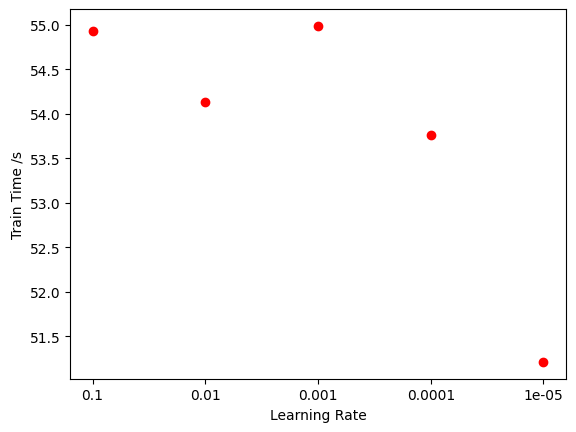

In [13]:
time_x = [str(1e-1), str(1e-2), str(1e-3), str(1e-4), str(1e-5)]
plt.scatter(time_x, time_list, c='r')
plt.xlabel('Learning Rate')
plt.ylabel('Train Time /s')
plt.show()

小结：

可以发现，在学习率为0.1时，由于学习率过大，模型损失经常震动。在学习率为1e-5时，由于学习率太小，200个epoch未能收敛。

在学习率适中的情况下，最后都收敛到接近0的loss，lr=1e-2、1e-3时仅需要20个ehopch即可收敛, lr=1e-4时则需要60个epoch才能收敛。

学习率对训练时间的影响似乎不大，五个不同的学习率的大小和训练时间不成正关系。

#### 3、网络宽度对模型的影响

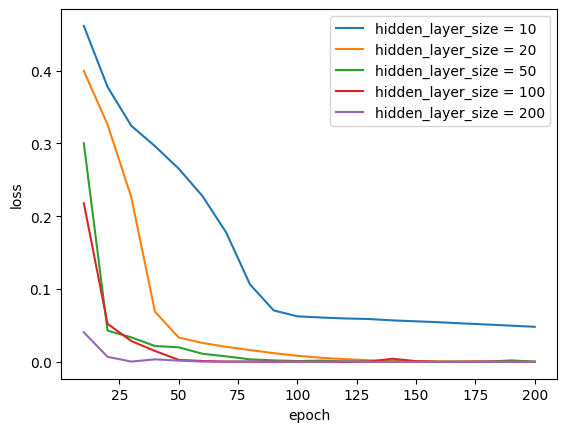

In [14]:
activation = 'ReLU'
validation_losses_dict = {}
hidden_layer_num = 4
time_list = []
for layer_size in [10, 20, 50, 100, 200]:
    validation_losses_dict[layer_size] = []
    model = Model(hidden_layer_num, layer_size, activation)
    n_gpu = torch.cuda.device_count()
    device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
    model = model.to(device)
    learning_rate = 3e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Loss = nn.MSELoss()
    epochs = 200
    start_time = time.time()
    for epoch in range(epochs):
        for batch_id, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = Loss(y, output)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
#             print('[Epoch {}/{}] Validation Loss = {:.5f}'
#             .format(epoch + 1, epochs, Loss(validation_y, model(validation_x))))
            validation_losses_dict[layer_size].append(float(Loss(validation_y, model(validation_x))))
    time_list.append(time.time()-start_time)

epoch_x = np.linspace(10, epochs, epochs//10).tolist()
for layer_size in [10, 20, 50, 100, 200]:
    plt.plot(epoch_x, validation_losses_dict[layer_size], label='hidden_layer_size = '+str(layer_size))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

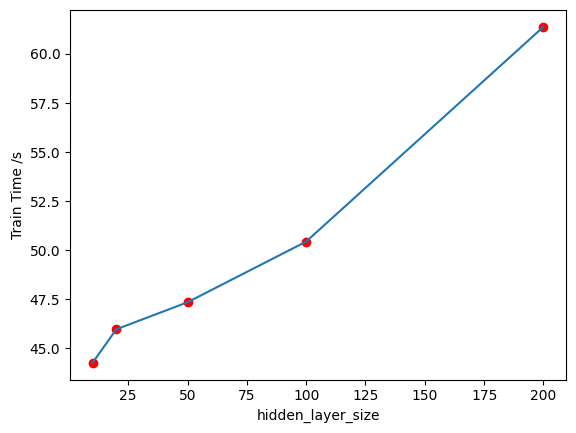

In [15]:
time_x = [10, 20, 50, 100, 200]
plt.scatter(time_x, time_list, c='r')
plt.plot(time_x, time_list)
plt.xlabel('hidden_layer_size')
plt.ylabel('Train Time /s')
plt.show()

小结：

由图可知，隐藏层较窄（如每层10个神经元）时，不能很好地表达目标函数，这时可能需要通过增加模型深度或宽度的方式增加模型的参数，以提高模型的表现能力。

在隐藏层达到一定深度时，模型可以收敛到接近0的loss。此时隐藏层越深，收敛需要的epoch越少，训练同样epoch花费的时间也越长。

#### 4、激活函数对模型的影响

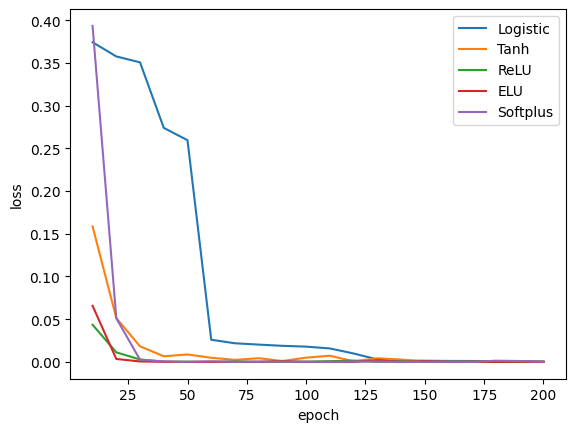

In [16]:
layer_size = 100
validation_losses_dict = {}
hidden_layer_num = 5
time_list = []
for activation in ['Logistic', 'Tanh', 'ReLU', 'ELU', 'Softplus']:
    validation_losses_dict[activation] = []
    model = Model(hidden_layer_num, layer_size, activation)
    n_gpu = torch.cuda.device_count()
    device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
    model = model.to(device)
    learning_rate = 3e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Loss = nn.MSELoss()
    epochs =200
    start_time = time.time()
    for epoch in range(epochs):
        for batch_id, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = Loss(y, output)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
#             print('[Epoch {}/{}] Validation Loss = {:.5f}'
#             .format(epoch + 1, epochs, Loss(validation_y, model(validation_x))))
            validation_losses_dict[activation].append(float(Loss(validation_y, model(validation_x))))
    time_list.append(time.time()-start_time)

epoch_x = np.linspace(10, epochs, epochs//10).tolist()
for activation in ['Logistic', 'Tanh', 'ReLU', 'ELU', 'Softplus']:
    plt.plot(epoch_x, validation_losses_dict[activation], label=str(activation))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

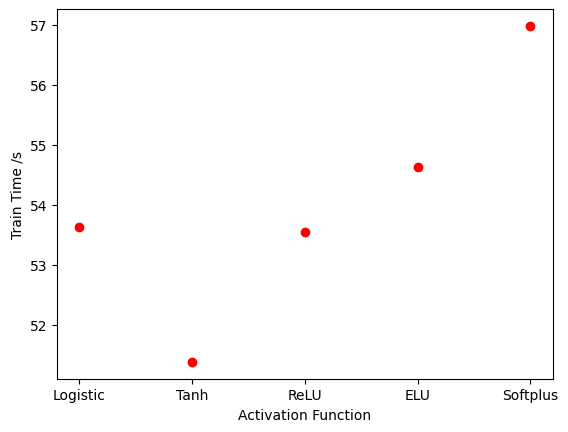

In [17]:
time_x = ['Logistic', 'Tanh', 'ReLU', 'ELU', 'Softplus']
plt.scatter(time_x, time_list, c='r')
plt.xlabel('Activation Function')
plt.ylabel('Train Time /s')
plt.show()

小结：

由图可知，不同激活函数对该模型收敛的速度有较大影响，可以看到使用ELU激活函数效果最好，Sigmoid最差。

由于激活函数计算时间不用，不同激活函数影响训练时间，比如计算复杂度较高的Softplus函数需要的训练时间最长。

## 三、测试集实验

选择超参数隐藏层层数=5，学习率=1e-4，网络宽度=100，激活函数为ELU进行重新训练

In [18]:
hidden_layer_num = 5
learning_rate = 1e-4
layer_size = 100
activation = 'ELU'
model = Model(hidden_layer_num, layer_size, activation)
n_gpu = torch.cuda.device_count()
device = torch.device('cuda:0' if n_gpu > 0 else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
Loss = nn.MSELoss()
epochs = 200
train_losses = []
test_losses = []
for epoch in range(epochs):
    for batch_id, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = Loss(y, output)
        loss.backward()
        optimizer.step()
    if (epoch+1)%10 == 0:
        print('[Epoch {}/{}] Train Loss = {:.4f}, Test Loss = {:.5f}'
        .format(epoch + 1, epochs, Loss(train_y, model(train_x)), Loss(test_y, model(test_x))))
        train_losses.append(float(Loss(train_y, model(train_x)).detach().numpy()))
        test_losses.append(float(Loss(test_y, model(test_x))))

[Epoch 10/200] Train Loss = 0.3413, Test Loss = 0.33365
[Epoch 20/200] Train Loss = 0.0858, Test Loss = 0.07767
[Epoch 30/200] Train Loss = 0.0478, Test Loss = 0.04243
[Epoch 40/200] Train Loss = 0.0089, Test Loss = 0.00809
[Epoch 50/200] Train Loss = 0.0010, Test Loss = 0.00083
[Epoch 60/200] Train Loss = 0.0003, Test Loss = 0.00027
[Epoch 70/200] Train Loss = 0.0001, Test Loss = 0.00012
[Epoch 80/200] Train Loss = 0.0001, Test Loss = 0.00005
[Epoch 90/200] Train Loss = 0.0000, Test Loss = 0.00004
[Epoch 100/200] Train Loss = 0.0000, Test Loss = 0.00002
[Epoch 110/200] Train Loss = 0.0000, Test Loss = 0.00002
[Epoch 120/200] Train Loss = 0.0000, Test Loss = 0.00002
[Epoch 130/200] Train Loss = 0.0000, Test Loss = 0.00002
[Epoch 140/200] Train Loss = 0.0000, Test Loss = 0.00004
[Epoch 150/200] Train Loss = 0.0000, Test Loss = 0.00001
[Epoch 160/200] Train Loss = 0.0000, Test Loss = 0.00001
[Epoch 170/200] Train Loss = 0.0000, Test Loss = 0.00002
[Epoch 180/200] Train Loss = 0.0000, Tes

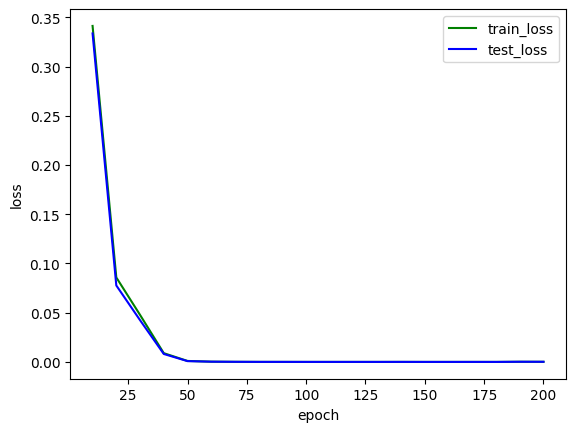

In [19]:
epoch_x = np.linspace(10, epochs, epochs//10).tolist()
plt.plot(epoch_x, train_losses, label="train_loss",color='g')
plt.plot(epoch_x, test_losses, label="test_loss",color='b')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

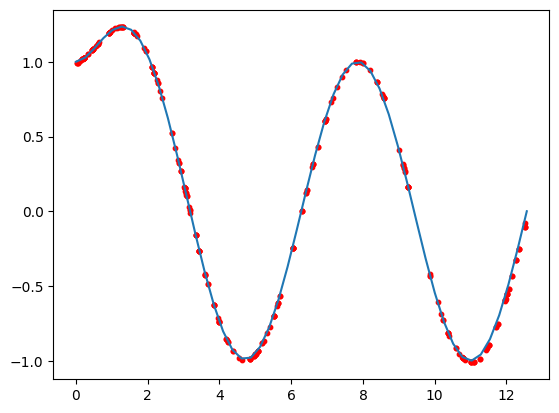

In [20]:
t = test_x.clone()
random.shuffle(t)
x = t[:300]
y = model(x).detach().numpy()
plt.scatter(x, y, s=10, c='r')

x = np.linspace(0, 4*np.pi)
plt.plot(x, np.sin(x)+np.exp(-x))

测试结果：

在测试集上的测试结果为MSE损失为0.00015，作出的图也可以发现散点离目标函数较近，所以模型可以较好地表达目标函数。